In [1]:
# file: feature_clustering_Clef.py
# Author: Anne Sabourin
# Description: CLEF tutorial (`unsupervised.feature_clustering' subpackage, `clef` submodule)

# CLEF tutorial

This notebook implements the CLEF algorithm as described in [1,
2]. The unsupervised task considered is the discovery of maximal
groups of components of a random vector that are comparatively likely
to be simultaneously large. Unlike DAMEX, the primary distinction is
that the subsets are constructed incrementally.  The goal is to
prevent false discoveries of subsets. Another difference is the CLEF is
not design to recover singleton features.  For a comparison between
CLEF and DAMEX, refer to the `compare_clef_damex` tutorial.

The tutorial relies on heuristic methods for selecting the tuning
parameter $\kappa$ in CLEF (ruling how far away a point must be from a
particular subspace of the sample space to be considered as 'not
belonging' to that subspace. These parameter selection methods have
not been considered in the original analysis in [1,2]. The approach
proposed in this tutorial (and in 'DAMEX' tutorial) rely on a
pseudo-likelihood (a dispersion metric à la Jorgensen) for random
subsets of features among $\{1, \ldots, d\}$. Although these methods
lack theoretical investigation, this notebook provides empirical
evidence supporting the relevance of the proposed selection
criteria. See the `feature_clustering_Damex` tutorial for further
details.

Alternative stopping criteria for CLEF based on asymptotic tests, as proposed in [2], are currently not implemented.

**References:**

[1] Chiapino, M., & Sabourin, A. (2016). Feature clustering for
extreme events analysis, with application to extreme stream-flow
data. In *International Workshop on New Frontiers in Mining Complex
Patterns* (pp. 132-147). Cham: Springer International Publishing.

[2] Chiapino, M., Sabourin, A., & Segers, J. (2019). Identifying
groups of variables with the potential of being large
simultaneously. *Extremes, 22*, 193-222.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pprint as pp
import MLExtreme as mlx


# Define the norm function as the infinite norm (other norms are not
# implemented in DAMEX / CLEF). This definition is not required for
# running CLEF/DAMEX and is used here solely for visualization and
# analysis of the output.

def norm_func(x):
    return np.max(x, axis=1)

## Ground truth definition:
Define or generate a list of subfaces of the unit sphere that
represent the support of the limit measure.

In [3]:
Plot = True
seed = 42
dim = 20  # try 5, 20, 50, 100
num_subfaces = 10  # try 5, 20, 50
subfaces_list = mlx.gen_subfaces(dimension=dim,
                                 num_subfaces=num_subfaces,
                                 max_size=5,  # try 4, 10, 20
                                 prevent_inclusions=True,
                                 seed=seed)

# # Uncomment for a simpler example:
# subfaces_list = [[0, 1], [1, 2], [2, 3, 4]]

if False:   # change to True to print the list of subfaces
    print(subfaces_list)
    pp.pprint(mlx.list_to_dict_size(subfaces_list))

subfaces_matrix = mlx.subfaces_list_to_matrix(subfaces_list, dim)
#print(subfaces_matrix)
# Dimension, number of mixture components, weights and Dirichlet center locations 
n = int(np.sqrt(dim) * 10**3)
k = np.shape(subfaces_matrix)[0]
dim = np.shape(subfaces_matrix)[1]
# Define admissible Dirichlet mixture parameters for the limit angular measure
# of a marginally Pareto-standardized heavy-tailed vector,
# based on the matrix of subfaces.
# This avoids potentially imbalanced settings across features.
wei = np.ones(k)/k
Mu, wei = mlx.normalize_param_dirimix(subfaces_matrix, wei)
# Print the subfaces and their weights, and record them as a list
# for further use.
faces_true = subfaces_list
wei_true = wei
print(f'Mu matrix: \n {np.round(Mu, 3)}')
print(f'Weights: {np.round(wei, 3)}')

Mu matrix: 
 [[0.333 0.    0.    0.333 0.    0.    0.    0.    0.333 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.174 0.13  0.261 0.    0.    0.174 0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.261]
 [0.103 0.414 0.138 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.138 0.    0.    0.    0.    0.207 0.   ]
 [0.097 0.    0.    0.    0.    0.    0.194 0.129 0.    0.    0.    0.
  0.    0.    0.    0.    0.387 0.    0.    0.194]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.4   0.    0.    0.    0.6   0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.25  0.    0.    0.    0.
  0.    0.    0.75  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.333 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.667 0.   ]
 [0.107 0.    0.    0.    0.    0.429 0.    0.    0.107 0.    0.214 0.
  0.    0.143 0.    0.    0.    0.    0.    0.   ]
 [0.    0. 

### Difficulty Settings for the Tail Problem

The `lnu` parameter below is the logarithm of the concentration
parameter for the Dirichlet mixture. It is a crucial parameter that
determines the difficulty of the clustering problem. If any
$\exp(\text{lnu}[i] ) \times \text{Mu}[i,j] < 1$, the problem is
pathologically hard, as the mass on any subface concentrates on the
boundary of that face. Conversely, if all $\exp(\text{lnu}[i]) \times
\text{Mu}[i,j] \gg 1$, the problem is very easy.

Experiment with the 'difficulty' parameter below, which should be
strictly positive. Values greater than one correspond to very hard
problems, while values close to zero generate very easy
problems. Interesting results occur for difficulty $\approx 0.8$.

In [4]:
difficulty = 0.8

min_mus = np.zeros(k)
for j in range(k):
    min_mus[j] = np.min(Mu[j, Mu[j, :] > 0])
lnu = np.log(1/(difficulty**2) * 1/min_mus)
# check (change to True  to display)
if False:
    print("absolute dirichlet parameters: ")
    print(Mu * np.exp(lnu).reshape(-1, 1))

 Other parameter settings that govern the speed of convergence of
the conditional distribution above a radial threshold towards the
limit measure.  

In [5]:
# Regular variation index of the data
alpha = 2

# Centers of mass of the Dirichlet mixture in the bulk (vanishing impact above large radial thresholds):
Mu_bulk = np.ones((k, dim))/dim

 `index_weight_noise` below indicates how fast the impact of noise decreases
with large radial thresholds. Specifically, the noise's weight decreases as:
$(C/\text{radius})^{\text{index\_weight\_noise}}$

In [6]:
index_weight_noise = 4 

### Dataset Generation and Visualisation

In [7]:
# Generate data 
np.random.seed(42)
X = mlx.gen_rv_dirimix(alpha, np.round(Mu, 3),  wei, lnu,
                       scale_weight_noise=1, Mu_bulk=Mu_bulk,
                       index_weight_noise=index_weight_noise, size=n)


# Define rank-transformed data
Xt = mlx.rank_transform(X)

# Generate test data for unsupervised evaluation
np.random.seed(12345)
Xtest = mlx.gen_rv_dirimix(alpha, np.round(Mu, 3),  wei, lnu,
                           scale_weight_noise=1, Mu_bulk=Mu_bulk,
                           index_weight_noise=index_weight_noise, size=5*n)

# Define rank-transformed test data
std_Xtest = mlx.rank_transform(Xtest)

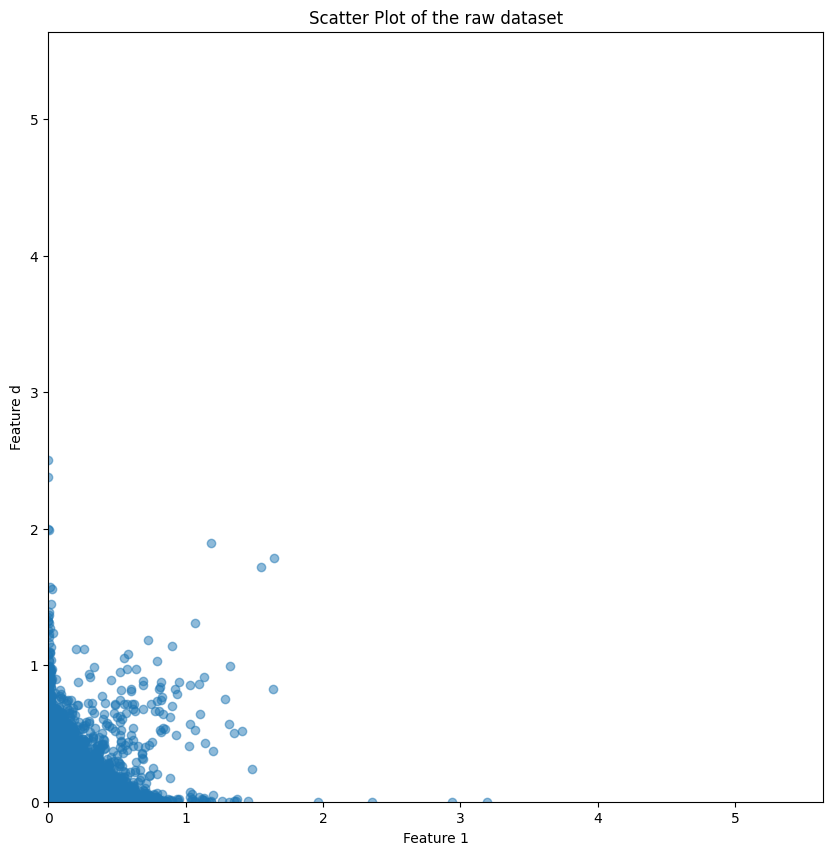

In [8]:
# pairwise plot of generated data for two dependent components
len_faces = np.sum(subfaces_matrix, axis=1)
r_i = np.where(len_faces > 1)[0][0]
iplot = subfaces_list[r_i][0]
jplot = subfaces_list[r_i][1]

if Plot:
    plt.figure(figsize=(10, 10))
    X_disp = X**(alpha/4)  # for easier visualization only
    max_val = np.max(X_disp)
    scatter = plt.scatter(X_disp[:, iplot], X_disp[:, jplot], alpha=0.5)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature d')
    plt.title('Scatter Plot of the raw dataset')
    plt.show()

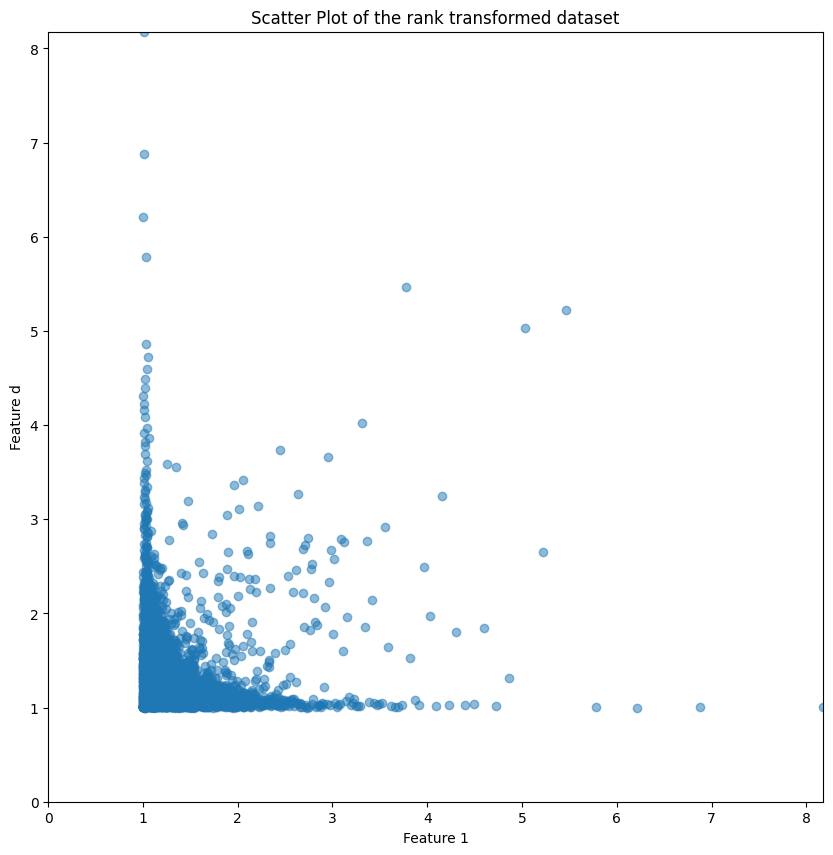

In [9]:
# Rank transformed  generated data with  unit Pareto margins
# and visualization
if Plot:
    plt.figure(figsize=(10, 10))
    X_disp = Xt**(1/4)  # for easier visualization only
    max_val = np.max(X_disp)
    scatter = plt.scatter(X_disp[:, iplot], X_disp[:, jplot], alpha=0.5)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature d')
    plt.title('Scatter Plot of the rank transformed dataset')
    plt.show()

# Data Analysis
## Radial threshold selection before model fitting

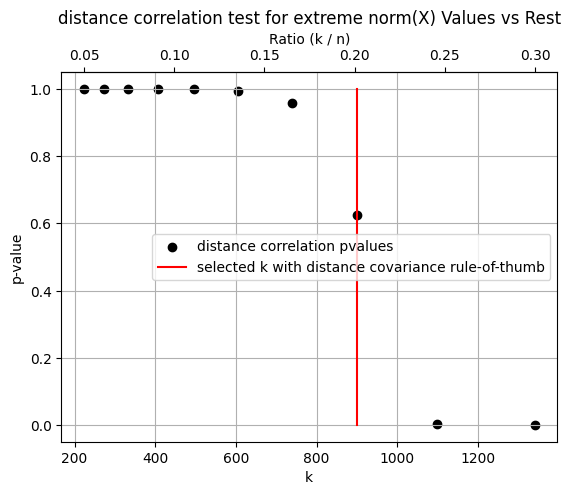

maximum ratio of extreme samples from rule-of-thumb distance covariance test: 0.2


In [10]:
# Select the radial threshold via distance-covariance tests.
# See the tutorials on classification and regression for more details.
ntests_thresh = 10
ratio_ext = np.geomspace(0.05, 0.3, num=ntests_thresh)
pval, ratio_max = mlx.test_indep_radius_rest(Xt, y=None, ratio_ext=ratio_ext,
                                             norm_func=norm_func)

if Plot:
    mlx.plot_indep_radius_rest(pval, ratio_ext, ratio_max, n)

print(f'maximum ratio of extreme samples from rule-of-thumb \
distance covariance test: {mlx.round_signif(ratio_max, 2)}')
ratio_extremes = ratio_max * 4/5
norm_Xt = norm_func(Xt)
# Radial threshold selected with rule-of-thumb radius-versus-rest
# independence tests:
threshold = np.quantile(norm_Xt, 1 - ratio_extremes)
# Note: The following is not 'k' in the notations of Goix et al.'s paper.
# Instead, it is between k and d * k. It is the number of data points above the radial threshold.
number_extremes = np.sum(norm_Xt >= threshold)

# %%%%%%%%%%%%%%%%%%%

# CLEF CLUSTERING ALGORITHM (Chiapino et al. , [1,2])

In [11]:
#create a CLEF clustering instance and fit it with default value kappa_min=0.1.
clusteringClef = mlx.clef(thresh_train=threshold, thresh_test=threshold)
clef_subfaces, clef_masses = clusteringClef.fit(X)

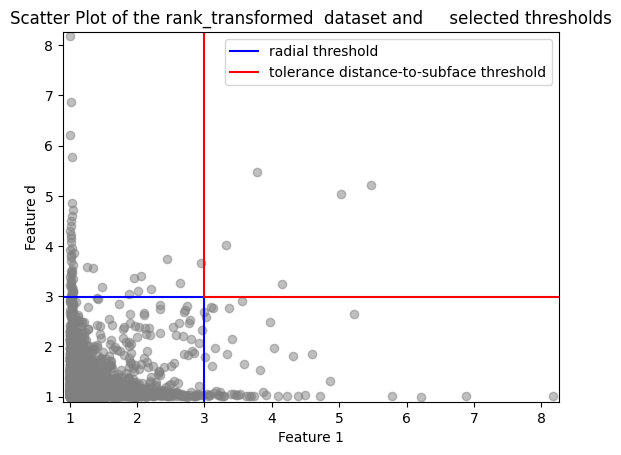

In [12]:
# Visualization of rank-transformed data and threshold (default; epsilon=0.1)
Xt_disp = Xt**(1/4)
thresh_disp = clusteringClef.thresh_train**(1/4)
eps_thresh_disp = (clusteringClef.thresh_train)**(1/4)
max_val = np.max(Xt_disp)*1.01
# NB: exponent alpha/4 above is meant to help visualization only. may
# be removed without altering  the analysis.
if Plot:
    scatter = plt.scatter(Xt_disp[:, iplot], Xt_disp[:, jplot], alpha=0.5,
                          c='gray')
    plt.xlim(0.9, max_val)
    plt.ylim(0.9, max_val)
    plt.plot([thresh_disp, thresh_disp], [0, thresh_disp], c='blue',
             label='radial threshold')
    plt.plot([0, thresh_disp], [thresh_disp, thresh_disp], c='blue')
    plt.plot([thresh_disp, max_val], [eps_thresh_disp, eps_thresh_disp],
             c='red',
             label='tolerance distance-to-subface threshold')
    plt.plot([eps_thresh_disp, eps_thresh_disp], [thresh_disp, max_val],
             c='red')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature d')
    plt.title('Scatter Plot of the rank_transformed  dataset and \
    selected thresholds')
    plt.legend()
    plt.show()

inspection of subfaces and masses

In [13]:
faces_dict_clef, mass_dict_clef = mlx.list_to_dict(clef_subfaces,
                                                   clef_masses)

faces_dict_true, mass_dict_true = mlx.list_to_dict(faces_true, wei_true)

if True:
    print("List of subfaces found by CLEF:")
    pp.pprint(faces_dict_clef)
    print("(CLEF) Associated limit mass:")
    print(mass_dict_clef)
    print("True  list of subfaces: ")
    pp.pprint(faces_dict_true)
    print("(True) Associated limit mass:")
    print(mass_dict_true)

List of subfaces found by CLEF:
{1: [],
 2: [[0, 5],
     [0, 8],
     [1, 2],
     [1, 18],
     [10, 5],
     [16, 6],
     [14, 7],
     [8, 18],
     [11, 12],
     [17, 13]],
 3: [[16, 19, 7]],
 4: [[2, 19, 4, 7], [2, 3, 4, 10], [2, 4, 6, 10]]}
(CLEF) Associated limit mass:
{1: [], 2: [0.036, 0.071, 0.089, 0.054, 0.11, 0.11, 0.25, 0.29, 0.36, 0.39], 3: [0.054], 4: [0.054, 0.0, 0.0]}
True  list of subfaces: 
{1: [[9], [15]],
 2: [[13, 17], [7, 14], [8, 18]],
 3: [[0, 3, 8]],
 4: [],
 5: [[2, 3, 4, 7, 19],
     [0, 1, 2, 13, 18],
     [0, 6, 7, 16, 19],
     [0, 5, 8, 10, 13],
     [2, 3, 4, 6, 10],
     [3, 8, 11, 12, 17]]}
(True) Associated limit mass:
{1: [0.05, 0.05], 2: [0.042, 0.067, 0.038], 3: [0.038], 4: [], 5: [0.096, 0.12, 0.13, 0.12, 0.1, 0.15]}


## Unsupervised scoring.
See the DAMEX tutorial for details.

In [14]:
# Deviance to true parameters: 
deviance_est_true, deviance_true_est = clusteringClef.deviance_to_true(
    faces_true, wei_true)


print("AIC deviance estimate of expected deviance:")
print(clusteringClef.get_AIC(Xt, standardize=False))

print("CV estimate of expected deviance")
print(np.mean(clusteringClef.deviance_CV(Xt, standardize=False)))
print("test set  estimate of expected deviance")
print(clusteringClef.deviance(std_Xtest, 
                              standardize=False))
print("Deviances between faces, masses: \
a) estimated to true b) true to estimated")
print(deviance_est_true, deviance_true_est)

AIC deviance estimate of expected deviance:
10.519137097826613
CV estimate of expected deviance
11.118973874513335
test set  estimate of expected deviance
10.941771606948306
Deviances between faces, masses: a) estimated to true b) true to estimated
10.299716679749482 13.174950547676474


For this sample size, AIC and CV appear to estimate relatively
well the expected deviance Additionally, the deviance between the true
parameters (faces and masses) and the estimated ones is, in principle,
similar to the test set estimate of the total deviance, which is also
observed here.

## Choosing Epsilon based on AIC / CV
Here and below we propose choosing epsilon in DAMEX using the AIC
criterion and  a CV-based selection rule (here
we retain the CV selection rule in the end). 

CLEF: selected kappa_min with AIC criterion: 0.07


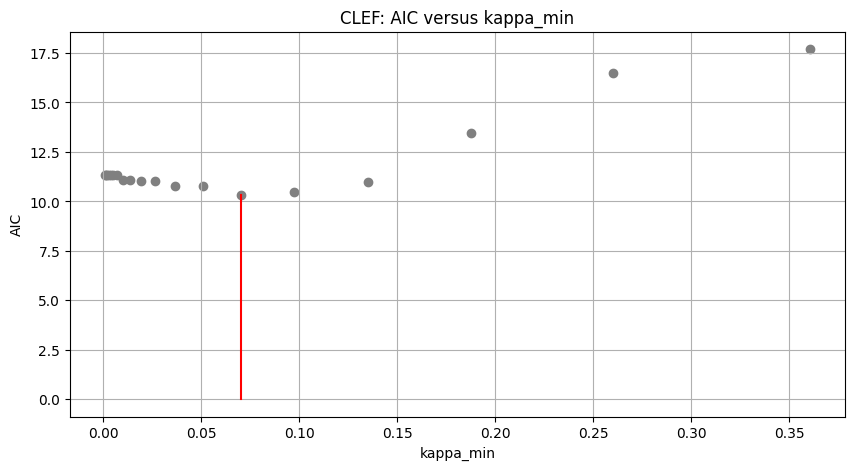

kappa_min parameter selection (AIC):
0.07
CLEF: selected kappa_min with CV estimate of deviance: 0.097


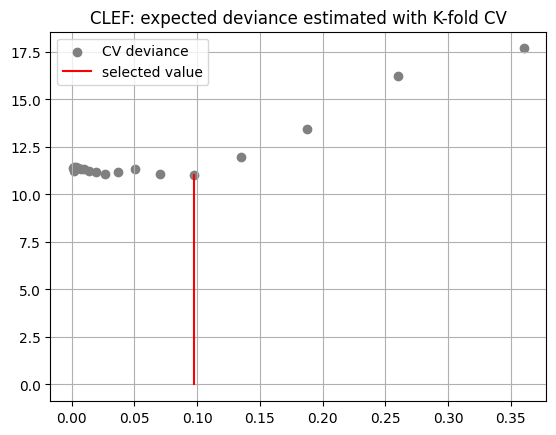

kappa_min parameter selection (CV):
0.097


0.1

In [15]:
# select kappa_min with AIC but don't update model:
nkappa = 20
kappa_vect = np.geomspace(10**(-3), 0.5, num=nkappa)
kappa_select_AIC, aic_opt, aic_values = clusteringClef.select_kappa_min_AIC(
    kappa_vect, X, update_kappa_min=False, plot=True)


print('kappa_min parameter selection (AIC):')
print(mlx.round_signif(kappa_select_AIC, 2))

# select kappa_min with CV but don't update model:
kappa_select_CV, _, _ = clusteringClef.select_kappa_min_CV(
    kappa_vect, X,  update_kappa_min=False, plot=True)

print('kappa_min parameter selection (CV):')
print(mlx.round_signif(kappa_select_CV, 2))

# check that kappa_min stored in object is still default one
clusteringClef.kappa_min

## wrapping up: comparison of all metrics:

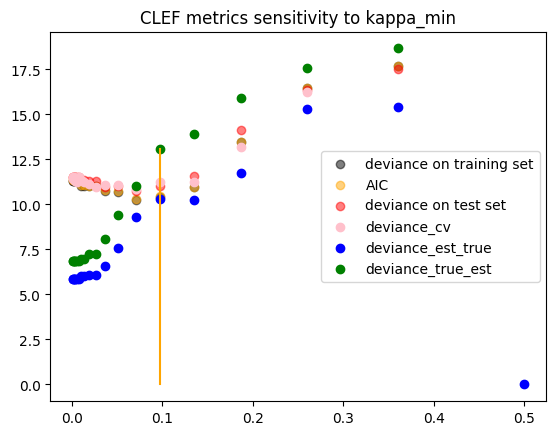

In [16]:
# agreement with other metrics: 
# recommended choice of kappa here: by CV
kappa_select = kappa_select_CV
i_select = np.where(kappa_select == kappa_vect)[0][0]
aic_vals = np.zeros(nkappa)
deviance = np.zeros(nkappa)
deviance_train = np.zeros(nkappa)
deviance_cv = np.zeros(nkappa)
deviance_est_true = np.zeros(nkappa)
deviance_true_est = np.zeros(nkappa)

for i in range(nkappa):
    clust = mlx.clef(kappa_min=kappa_vect[i], thresh_train=threshold,
                     thresh_test=threshold)
    faces, masses = clust.fit(Xt, standardize=False)
    aic_vals[i] = clust.get_AIC(Xt,  standardize=False)
    deviance[i] = clust.deviance(
        std_Xtest,
        standardize=False)
    deviance_train[i] = clust.deviance(Xt,  standardize=False)
    deviance_cv_scores = clust.deviance_CV(
        Xt, standardize=False,
        random_state=13+137*i, cv=5)
    deviance_cv[i] = np.mean(deviance_cv_scores)
    deviance_est_true[i], deviance_true_est[i] = clust.deviance_to_true(
        faces_true, wei_true)

if True:
    plt.scatter(kappa_vect, deviance_train, c='black',
                label='deviance on training set', alpha=0.5)
    plt.scatter(kappa_vect, aic_vals, c='orange', label='AIC', alpha=0.5)
    plt.scatter(kappa_vect, deviance, c='red',
                label='deviance on test set', alpha=0.5)
    plt.scatter(kappa_vect, deviance_cv, c='pink',
                label='deviance_cv')
    plt.scatter(kappa_vect, deviance_est_true, c='blue',
                label='deviance_est_true')
    plt.scatter(kappa_vect, deviance_true_est, c='green',
                label='deviance_true_est')
    plt.plot([kappa_select, kappa_select], [0, deviance_true_est[i_select]],
             c='orange')
    plt.legend()
    plt.title("CLEF metrics sensitivity to kappa_min")
    plt.show()

*Conclusion:*

All goes as planned:

    - deviance on testing set and AIC are very close or even
     indistinguishable as soon as kappa_min is not too small, reflecting
     the fact that AIC is a consistent estimate of the deviance on a
     test set.

    - deviance on train set and AIC are close because the number of
      'parameters' of the mode (i.e. number of faces) is small
      compared with the sample size (here, the number of extremes)

    - deviance on train is close, but less than, deviance on test,
      reflecting slight overfitting.

    - deviance on test is a reasonable approximation of the deviance
      of the estimated parameter from the true model (not the other
      way around, think about it)

- CV deviance is different from test deviance but follows a similar pattern.

*Recommendation* 
To choose kappa_min, use `select_kappa_min_AIC ` and
   `select_kappa_min_CV'. The results should be similar. If they are
   not, you are in trouble because the (extreme) sample size may be too small.

In [17]:

# Re-fit the model with previously selected epsilon and inspect
# subfaces and masses

subfaces_select, masses_select = clusteringClef.fit(Xt, kappa_select, False)
weights_select = masses_select / np.sum(masses_select)

dict_faces_select, dict_weights_select = mlx.list_to_dict(subfaces_select,
                                                          weights_select)

print("CLEF with selected kappa_min: subfaces")
pp.pprint(dict_faces_select)
print("True subfaces")
pp.pprint(faces_dict_true)

print("final output: weights = normalized masses")
pp.pprint(dict_weights_select)
print("True weights")
pp.pprint(mass_dict_true)

CLEF with selected kappa_min: subfaces
{1: [],
 2: [[0, 5],
     [0, 8],
     [0, 16],
     [1, 2],
     [1, 13],
     [1, 18],
     [10, 5],
     [14, 7],
     [8, 18],
     [11, 12],
     [17, 13]],
 3: [[16, 6, 7], [16, 19, 7]],
 4: [[2, 3, 4, 10], [2, 4, 6, 10], [2, 19, 4, 7]]}
True subfaces
{1: [[9], [15]],
 2: [[13, 17], [7, 14], [8, 18]],
 3: [[0, 3, 8]],
 4: [],
 5: [[2, 3, 4, 7, 19],
     [0, 1, 2, 13, 18],
     [0, 6, 7, 16, 19],
     [0, 5, 8, 10, 13],
     [2, 3, 4, 6, 10],
     [3, 8, 11, 12, 17]]}
final output: weights = normalized masses
{1: [],
 2: [0.019, 0.038, 0.019, 0.047, 0.038, 0.028, 0.057, 0.13, 0.15, 0.19, 0.21],
 3: [0.019, 0.028],
 4: [0.0, 0.0, 0.028]}
True weights
{1: [0.05, 0.05],
 2: [0.042, 0.067, 0.038],
 3: [0.038],
 4: [],
 5: [0.096, 0.12, 0.13, 0.12, 0.1, 0.15]}
